# Enhancing Human Decision-Making through Generative Curation



To create the curated set of options, we would utilize a stochastic policy $\pi(a)$ that creates a probability distribution over the action space,
enabling the decision-maker to sample $m$ actions. As the policy-maker is assumed to choose the action that maximizes the total desirability, the goal of our algorithm is therefore to maximize the total desirability of the best action among the $m$ sampled actions:
\begin{equation}
    \max_{A_1,\cdots, A_m \sim \pi(a)}~\max_{i=1,\cdots,m}~p Y(A_i) + (1-p) U(A_i)
\end{equation}
where $p$ refers to the relative weight between the two objectives. By assumption, the qualitative part of the desirability cannot be estimated through the historical data, and therefore we require a concrete assumption about its structure.

### Data Synthesizer

Consider the scenario where a human decision-maker needs to make a policy decision $a \subseteq \mathbb{R}^q$ from a large, possibly infinite set of potential actions. The goal is to maximize the *desirability* of the actions. The decision-maker is aided by historical data of the form $D = \{(y_i, a_i)\}_{i=1}^n$ where $y_i \in \mathbb{R}$ measures the quantifiable desirability (*e.g.*, outcome) of the action.

In the following simplified example, actions are sampled uniformly between 0 and 1, and the underlying objective function is Gaussian with the action as its input. The observed outcome is the objective value with added Gaussian noise having zero mean and a specified standard deviation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from abc import abstractmethod

class QuantitativeDesirability(object):
    """
    A class representing the quantitative desirability.
    """
    @abstractmethod
    def __init__(self, supp_A=[0,1]):
        super(QuantitativeDesirability, self).__init__()
        self.supp_A = supp_A # Support of the actions

    @abstractmethod
    def Y(self, a):
        """
        Returns a function that measures the quantitative desirability of an action.
        """
        raise NotImplementedError()

    def y(self, a):
        """
        Returns the observed outcome of an action.
        """
        return self.Y(a)


    def generate_a(self, num_samples=100):
        """
        Generates a set of actions.
        """
        actions = np.random.uniform(self.supp_A[0], self.supp_A[1], num_samples)
        return actions

    def generate_y(self, a):
        """
        Generates the observed outcomes of the actions.
        """
        return self.y(a)

class UniModalDesirability(QuantitativeDesirability):
    """
    The quantitative desirability represented by a unimodal function.
    """
    def __init__(self, supp_A=[0,1]):
        super(UniModalDesirability, self).__init__(supp_A=supp_A)

    def Y(self, a, mean=.5, std_dev=.2):
    # def Y(self, a, mean=.5, std_dev=.08):
        """
        Returns a function that measures the quantitative desirability of an action.
        """
        return np.exp(-0.5 * ((a - mean) / std_dev) ** 2)

    def y(self, a, mean=.5):
        """
        Returns the observed outcome of an action.
        """
        return super(UniModalDesirability, self).y(a) + np.random.normal(0, self._noise_level(a, mean), num_samples)

    def _noise_level(self, a, m):
        """
        Returns the noise level of an action.
        """
        NOISE_FACTOR = 0.1
        return NOISE_FACTOR * (0.5 - np.abs(a - m)) ** 2

class BiModalDesirability(QuantitativeDesirability):
    """
    The quantitative desirability represented by a unimodal function.
    """
    def __init__(self, supp_A=[0,1]):
        super(BiModalDesirability, self).__init__(supp_A=supp_A)

    def Y(self, a, mean_1=.3, mean_2=.7, std_dev_1=.08, std_dev_2=.08):
        """
        Returns a function that measures the quantitative desirability of an action.
        """
        return np.exp(-0.25 * ((a - mean_1) / std_dev_1) ** 2) + \
               np.exp(-0.25 * ((a - mean_2) / std_dev_2) ** 2)

    def y(self, a, mean=.5):
        """
        Returns the observed outcome of an action.
        """
        return super(BiModalDesirability, self).y(a) + np.random.normal(0, .1, num_samples)

class TriModalDesirability(QuantitativeDesirability):
    """
    The quantitative desirability represented by a unimodal function.
    """
    def __init__(self, supp_A=[0,1]):
        super(TriModalDesirability, self).__init__(supp_A=supp_A)

    def Y(self, a, mean_1=.15, mean_2=.5, mean_3=.85, std_dev_1=.08, std_dev_2=.08, std_dev_3=.08):
        """
        Returns a function that measures the quantitative desirability of an action.
        """
        return np.exp(-0.25 * ((a - mean_1) / std_dev_1) ** 2) + \
               np.exp(-0.25 * ((a - mean_2) / std_dev_2) ** 2) + \
               np.exp(-0.25 * ((a - mean_3) / std_dev_3) ** 2)

    def y(self, a, mean=.5):
        """
        Returns the observed outcome of an action.
        """
        return super(TriModalDesirability, self).y(a) + np.random.normal(0, .1, num_samples)

class QualitativeDesirability(object):
    """
    A class representing the qualitative desirability.
    """

    def __init__(self, supp_A=[0,1]):
        self.supp_A = supp_A # Support of the actions

    def U(self, a):
        """
        Returns a function that measures the qualitative desirability of an action.
        """
        mean = np.zeros(a.shape)
        a    = a.reshape(-1, 1)
        dist = cdist(a, a, 'euclidean')
        cov  = self.exponential_kernel(dist)
        return np.random.multivariate_normal(mean, cov)

    # Define the exponential kernel function
    def exponential_kernel(self, dist, length_scale=5e-2):
        """
        Exponential kernel function.
        """
        return np.exp(- 0.5 * dist ** 2 / length_scale ** 2)

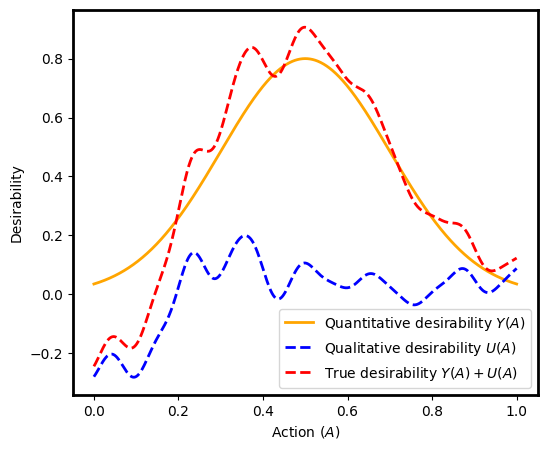

In [ ]:
# Parameters
num_samples   = 100    # Number of samples
std_dev_noise = 0.1    # Standard deviation of Gaussian noise
p             = 0.8    # Relative weight between the two objectives
supp_A        = [0, 1] # Support of the actions
n_grid        = 1e3    # Number of grid in action space

# Generate observed actions and outcomes
uQtD      = UniModalDesirability(supp_A) # QuantitativeDesirability(supp_A)
QlD       = QualitativeDesirability(supp_A)
uactions  = uQtD.generate_a(num_samples)
uoutcomes = uQtD.generate_y(uactions)

# Generate underlying qualitative & quantitative desirability
A   = np.linspace(supp_A[0], supp_A[1], int(n_grid))
U   = QlD.U(A)
uY  = uQtD.Y(A)
uD  = p * uY + (1 - p) * U

# Plot the generated data and the corresponding groundtruth
fig, ax = plt.subplots(figsize=(6, 5))
# plt.scatter(uactions, p * uoutcomes, label='Observed Outcome', color='red', alpha=0.3)
ax.plot(A, p * uY, color='orange', linewidth=2, label='Quantitative desirability $Y(A)$')
ax.plot(A, (1 - p) * U, color='blue', linestyle='--', linewidth=2, label='Qualitative desirability $U(A)$')
ax.plot(A, uD, color='red', linestyle='--', linewidth=2, label='True desirability $Y(A)+U(A)$')
plt.xlabel('Action ($A$)')
plt.ylabel('Desirability')
# plt.title('Generated Data')
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner

plt.legend()
plt.show()

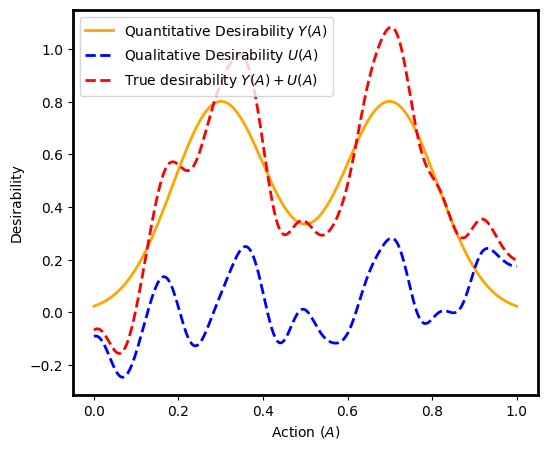

In [ ]:
# Generate observed actions and outcomes
bQtD      = BiModalDesirability(supp_A) # QuantitativeDesirability(supp_A)
QlD       = QualitativeDesirability(supp_A)
bactions  = bQtD.generate_a(num_samples)
boutcomes = bQtD.generate_y(bactions)

# Generate underlying qualitative & quantitative desirability
A   = np.linspace(supp_A[0], supp_A[1], int(n_grid))
U   = QlD.U(A)
bY  = bQtD.Y(A)
bD  = p * bY + (1 - p) * U

# Plot the generated data and the corresponding groundtruth
fig, ax = plt.subplots(figsize=(6, 5))
# plt.scatter(bactions, p * boutcomes, label='Observed Outcome', color='red', alpha=0.3)
ax.plot(A, p * bY, color='orange', linewidth=2, label='Quantitative Desirability $Y(A)$')
ax.plot(A, (1 - p) * U, color='blue', linestyle='--', linewidth=2, label='Qualitative Desirability $U(A)$')
ax.plot(A, bD, color='red', linestyle='--', linewidth=2, label='True desirability $Y(A)+U(A)$')
plt.xlabel('Action ($A$)')
plt.ylabel('Desirability')
# plt.title('Generated Data')
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner

plt.legend()
plt.show()

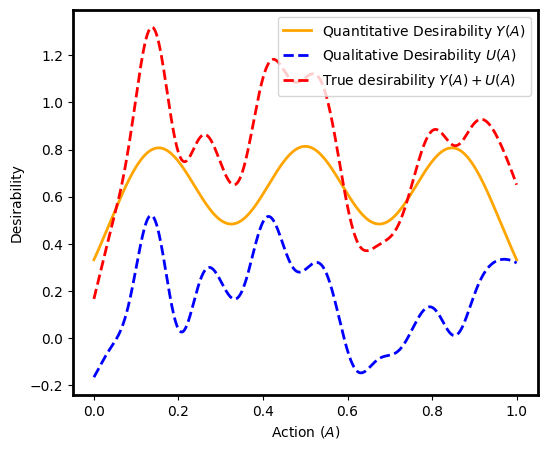

In [ ]:
# Generate observed actions and outcomes
tQtD      = TriModalDesirability(supp_A) # QuantitativeDesirability(supp_A)
QlD       = QualitativeDesirability(supp_A)
tactions  = tQtD.generate_a(num_samples)
toutcomes = tQtD.generate_y(tactions)

# Generate underlying qualitative & quantitative desirability
A   = np.linspace(supp_A[0], supp_A[1], int(n_grid))
U   = QlD.U(A)
tY  = tQtD.Y(A)
tD  = p * tY + (1 - p) * U

# Plot the generated data and the corresponding groundtruth
fig, ax = plt.subplots(figsize=(6, 5))
# plt.scatter(bactions, p * boutcomes, label='Observed Outcome', color='red', alpha=0.3)
ax.plot(A, p * tY, color='orange', linewidth=2, label='Quantitative Desirability $Y(A)$')
ax.plot(A, (1 - p) * U, color='blue', linestyle='--', linewidth=2, label='Qualitative Desirability $U(A)$')
ax.plot(A, tD, color='red', linestyle='--', linewidth=2, label='True desirability $Y(A)+U(A)$')
plt.xlabel('Action ($A$)')
plt.ylabel('Desirability')
# plt.title('Generated Data')
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner

plt.legend()
plt.show()

### Policy Diversity $\rho[\pi]$

Now since $A_1,\cdots, A_m$ are *i.i.d.* samples from a distribution $\pi(a)$, and $U$ is a stationary gaussian process, the joint distribution of $U(A_1),\cdots, U(A_m)$ therefore follows an equicorrelated joint normal distribution with covariance:
$$
\rho^2[\pi] = Cov(U(A_i),U(A_j)) = \int \int k(a, a') \pi(a)\pi(a') d a d a'.
$$
In particular, this means that there exists $S_i \sim N(0, 1-\rho^2[\pi])$ and $T \sim N(0,\rho^2[\pi])$ independent of $S_i$ such that:
$U(A_i)= S_i + T$. Therefore, we have:
\begin{equation*}
    \mathbb{E}[\max\{U(A_1),\cdots, U(A_m)\}]=\mathbb{E}[\max\{S_1,\cdots, S_m\}] + \mathbb{E}[T] = \sqrt{1-\rho^2[\pi]}E_m
\end{equation*}
where: $E_m = \int^\infty_{-\infty} x d/dx \Phi(x)^m dx$ and $\Phi(x)$ is the CDF of the standard normal distribution. Therefore, our optimization problem becomes:
$$
\max_{A_1,A_2,\cdots, A_m \sim \pi(a)} \mathbb{E}[p\max\{Y(A_1),\cdots, Y(A_m)\}] + (1-p)\sqrt{1-\rho^2[\pi]} E_m
$$

In [ ]:
class Policy(object):
    """
    A class representing a general policy.
    """
    @abstractmethod
    def __init__(self, QtD=None, supp_A=[0,1], n_grid=1e3):
        super(Policy, self).__init__()
        self.supp_A = supp_A # Support of the actions
        self.A      = np.linspace(self.supp_A[0], self.supp_A[1], int(n_grid))
        self.QtD    = QtD    # Quantitative desirability

    @abstractmethod
    def generate(self, num_samples=10):
        """
        Generates a set of actions.
        """
        raise NotImplementedError()

class Diversity(object):
    """
    A class representing the diversity of a policy.
    """
    def __init__(self, policy, QlD, supp_A=[0,1], n_grid=1e3):
        self.policy = policy
        self.QlD    = QlD    # Qualitative desirability
        self.supp_A = supp_A # Support of the actions
        self.A      = np.linspace(self.supp_A[0], self.supp_A[1], int(n_grid))

    def rho(self, num_samples=100):
        """
        Returns the diversity of a policy given the qualitative desirability.
        """
        A1, _ = self.policy.generate(num_samples)
        A2, _ = self.policy.generate(num_samples)
        dist  = np.sqrt((A1 - A2) ** 2)
        K     = self.QlD.exponential_kernel(dist)
        return np.mean(K)

### $\epsilon$-Optimal Uniform Policy

In this section, we want to study the dynamics of the objective function with a $\epsilon$-optimal uniform policy.
Let $\epsilon$ be the degree of sub-optimality.
The $\epsilon$-optimal uniform policy $\pi(a)$ is uniform on all actions that are $\epsilon$-optimal. The support of all $\epsilon$-optimal solutions is size $g(\epsilon)$ (*i.e.*, the distribution is $\pi(a)=1 / g(\epsilon)$ on all $\epsilon$-optimal sizes.

In [ ]:
class EpsilonOptimalUniformPolicy(Policy):
    """
    A class representing the epsilon-optimal uniform policy.
    """
    def __init__(self, eps, QtD, supp_A=[0,1], n_grid=1e3):
        super(EpsilonOptimalUniformPolicy, self).__init__(QtD=QtD, supp_A=supp_A, n_grid=n_grid)
        self.eps    = eps
        self.max_Y, self.eps_Y, self.eps_inds = self._policy_support()

    def _policy_support(self):
        """
        Returns the support of the epsilon-optimal uniform policy.
        """
        Y        = self.QtD.Y(self.A)
        max_Y    = np.max(Y)
        eps_Y    = max_Y - self.eps
        _inds    = np.where(Y >= eps_Y)[0]
        return max_Y, eps_Y, _inds

    def generate(self, num_samples=10):
        """
        Generates a set of actions.
        """
        # actions = np.random.choice(self.eps_supp, size=num_samples, replace=True)
        gen_inds    = np.random.choice(self.eps_inds, size=num_samples, replace=True)
        gen_actions = self.A[gen_inds]
        return gen_actions, gen_inds

Generated actions: [0.5975976  0.57357357 0.45945946 0.38838839 0.47047047 0.54154154
 0.65765766 0.69269269 0.52952953 0.57357357]
True desirability is 0.906472
Max desirability of generated actions is 0.864715


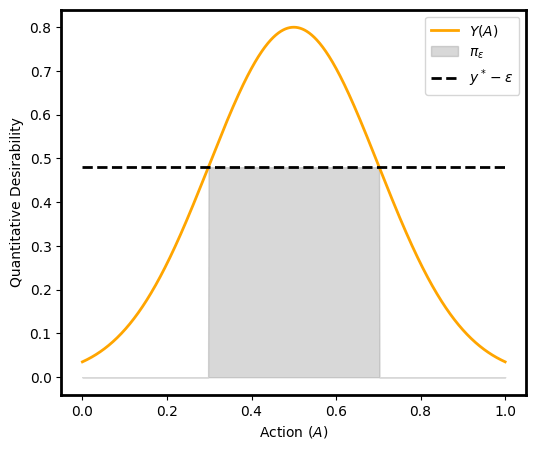

In [ ]:
# Parameters
eps = 0.4 # epsilon-optimality

policy = EpsilonOptimalUniformPolicy(eps=eps, QtD=uQtD, supp_A=supp_A, n_grid=n_grid)
gen_A, gen_inds = policy.generate(10)
print("Generated actions:", gen_A)

gen_D = uD[gen_inds]
print("True desirability is %f" % np.max(uD))
print("Max desirability of generated actions is %f" % np.max(gen_D))

# Plot the groundtruth and the corresponding epsilon optimality
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(A, p * uY, color='orange', linewidth=2, label='$Y(A)$')
plt.fill_between(A, np.zeros(len(A)), np.array([ p * policy.eps_Y if y >= policy.eps_Y else 0 for y in uY]), color='gray', alpha=0.3, label='$\pi_\epsilon$')
# plt.plot(A, p * uY + (1 - p) * U, color='red', linestyle='--', linewidth=2, label='$Y(A)+U(A)$')
# plt.plot(A, (1 - p) * U, color='blue', linestyle='--', linewidth=2, label='$U(A)$')
plt.hlines(p * policy.eps_Y, xmin=0., xmax=1., colors='black', linewidth=2, linestyles='--', label='$y^* - \epsilon$')
# plt.scatter(gen_A, p * policy.eps_Y * np.ones(len(gen_A)), label='$A \sim \pi$', color='black', alpha=0.8)
plt.xlabel('Action ($A$)')
plt.ylabel('Quantitative Desirability')
# plt.title('$\epsilon$-Optimality')
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner

plt.legend()
plt.show()

Generated actions: [0.40940941 0.65265265 0.51451451 0.65065065 0.61861862 0.65465465
 0.53853854 0.35535536 0.5995996  0.63763764]
True desirability is 1.071430
Max desirability of generated actions is 1.009930


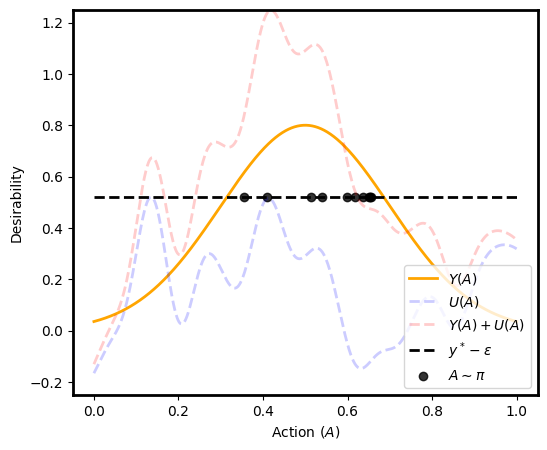

In [ ]:
# Parameters
eps = 0.35 # epsilon-optimality

policy = EpsilonOptimalUniformPolicy(eps=eps, QtD=uQtD, supp_A=supp_A, n_grid=n_grid)
gen_A, gen_inds = policy.generate(10)
print("Generated actions:", gen_A)

gen_D = uD[gen_inds]
print("True desirability is %f" % np.max(uD))
print("Max desirability of generated actions is %f" % np.max(gen_D))

# Plot the groundtruth and the corresponding epsilon optimality
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(A, p * uY, color='orange', linewidth=2, label='$Y(A)$')
plt.plot(A, (1 - p) * U, color='blue', linestyle='--', linewidth=2, label='$U(A)$', alpha=.2)
plt.plot(A, p * uY + (1 - p) * U, color='red', linestyle='--', linewidth=2, label='$Y(A)+U(A)$', alpha=.2)
plt.hlines(p * policy.eps_Y, xmin=0., xmax=1., colors='black', linewidth=2, linestyles='--', label='$y^* - \epsilon$')
plt.scatter(gen_A, p * policy.eps_Y * np.ones(len(gen_A)), label='$A \sim \pi$', color='black', alpha=0.8)
plt.xlabel('Action ($A$)')
plt.ylabel('Desirability')
plt.ylim(-.25, 1.25)
# plt.title('$\epsilon$-Optimality')
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner

plt.legend(loc='lower right')
plt.show()

Generated actions: [0.22122122 0.1961962  0.28728729 0.62462462 0.68468468 0.74474474
 0.76376376 0.77377377 0.74374374 0.34534535]
True desirability is 0.927158
Max desirability of generated actions is 0.834770


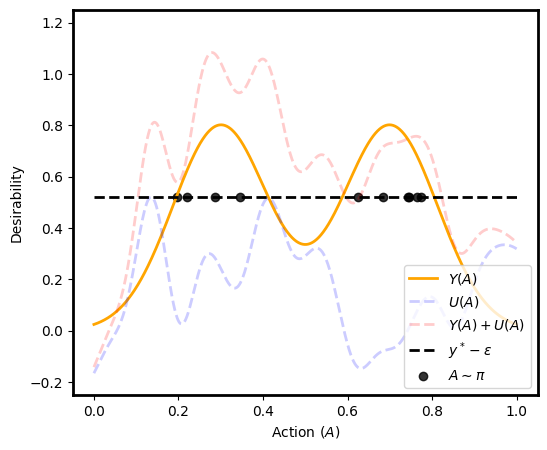

In [ ]:
# Parameters
eps = 0.35 # epsilon-optimality

policy = EpsilonOptimalUniformPolicy(eps=eps, QtD=bQtD, supp_A=supp_A, n_grid=n_grid)
gen_A, gen_inds = policy.generate(10)
print("Generated actions:", gen_A)

gen_D = bD[gen_inds]
print("True desirability is %f" % np.max(bD))
print("Max desirability of generated actions is %f" % np.max(gen_D))

# Plot the groundtruth and the corresponding epsilon optimality
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(A, p * bY, color='orange', linewidth=2, label='$Y(A)$')
ax.plot(A, (1 - p) * U, color='blue', linestyle='--', linewidth=2, label='$U(A)$', alpha=.2)
ax.plot(A, p * bY + (1 - p) * U, color='red', linewidth=2, linestyle='--', label='$Y(A)+U(A)$', alpha=.2)
ax.hlines(p * policy.eps_Y, xmin=0., xmax=1., colors='black', linewidth=2, linestyles='--', label='$y^* - \epsilon$')
ax.scatter(gen_A, p * policy.eps_Y * np.ones(len(gen_A)), label='$A \sim \pi$', color='black', alpha=0.8)
plt.xlabel('Action ($A$)')
plt.ylabel('Desirability')
plt.ylim(-.25, 1.25)
# plt.title('$\epsilon$-Optimality')
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner

plt.legend(loc='lower right')
plt.show()

Generated actions: [0.3953954  0.8968969  0.13213213 0.19119119 0.71971972 0.78678679
 0.90990991 0.79279279 0.87887888 0.27327327]
True desirability is 0.927158
Max desirability of generated actions is 1.312045


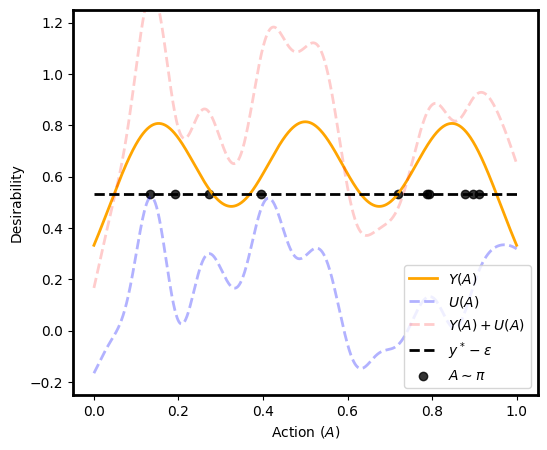

In [ ]:
# Parameters
eps = 0.35 # epsilon-optimality

policy = EpsilonOptimalUniformPolicy(eps=eps, QtD=tQtD, supp_A=supp_A, n_grid=n_grid)
gen_A, gen_inds = policy.generate(10)
print("Generated actions:", gen_A)

gen_D = tD[gen_inds]
print("True desirability is %f" % np.max(bD))
print("Max desirability of generated actions is %f" % np.max(gen_D))

# Plot the groundtruth and the corresponding epsilon optimality
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(A, p * tY, color='orange', linewidth=2, label='$Y(A)$')
ax.plot(A, (1 - p) * U, color='blue', linestyle='--', linewidth=2, label='$U(A)$', alpha=.3)
ax.plot(A, p * tY + (1 - p) * U, color='red', linestyle='--', linewidth=2, label='$Y(A)+U(A)$', alpha=.2)
ax.hlines(p * policy.eps_Y, xmin=0., xmax=1., colors='black', linewidth=2, linestyles='--', label='$y^* - \epsilon$')
ax.scatter(gen_A, p * policy.eps_Y * np.ones(len(gen_A)), label='$A \sim \pi$', color='black', alpha=0.8)
plt.xlabel('Action ($A$)')
plt.ylabel('Desirability')
plt.ylim(-.25, 1.25)
# plt.title('$\epsilon$-Optimality')
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner

plt.legend(loc='lower right')
plt.show()

##### Regret vs $\epsilon$

In [ ]:
# import os
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# datapath = "gdrive/MyDrive/Projects/Generative Curation"
# os.chdir(datapath)

def compute_regret_vs_eps(QtD, QlD, eps_min=.005, eps_max=.5, n_eps=40, supp_A=[0,1], n_grid=1e3):
    """
    Computes the regret vs epsilon.
    """
    p = 0.8
    A = np.linspace(supp_A[0], supp_A[1], int(n_grid))

    regrets_D =[]
    regrets_Y =[]
    rhos     = []
    for eps in np.linspace(eps_min, eps_max, n_eps):
        policy    = EpsilonOptimalUniformPolicy(eps=eps, QtD=QtD, supp_A=supp_A, n_grid=n_grid)
        diversity = Diversity(policy=policy, QlD=QlD, supp_A=supp_A, n_grid=n_grid)
        rho       = diversity.rho()
        regret_D   = []
        regret_Y   = []
        for n in range(20):
            # Y and D
            U     = QlD.U(A)
            Y     = QtD.Y(A)
            D     = p * Y + (1 - p) * U
            # generated Y and D
            _, _inds = policy.generate(10)
            _D       = D[_inds]
            _Y       = Y[_inds]
            # regret D
            rD = np.max(D) - np.max(_D)
            assert rD >= 0, "Regret must be positive!"
            regret_D.append(rD)
            # regret Y
            rY = np.max(Y) - np.max(_Y)
            assert rY >= 0, "Regret must be positive!"
            regret_Y.append(rY)
        print("eps: %.3f, regret D: %.5f, regret Y: %.5f, rho^2: %.5f" % \
            (eps, np.mean(regret_D), np.mean(regret_Y), rho))

        rhos.append(rho)
        regrets_D.append(regret_D)
        regrets_Y.append(regret_Y)

    return regrets_D, regrets_Y, rhos

def moving_average(arr, window_size):
    """
    Compute the moving average of a 1D array with a given window size and remove NaN values.

    Parameters:
    arr (list or np.ndarray): The input array of values.
    window_size (int): The size of the moving average window.

    Returns:
    np.ndarray: The moving average of the input array with NaN values removed.
    """
    # Ensure the window size is valid
    if window_size is None:
        return arr

    # Convert the input array to a numpy array if it is not already
    arr = np.asarray(arr)

    # Compute the moving average using convolution
    cumsum = np.cumsum(arr, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    moving_avg = cumsum[window_size - 1:] / window_size

    return moving_avg

def plot_regret_vs_eps(epss, regrets_D, regrets_Y, rhos, lpct=20, upct=80, window_size=None, policy_name='$\epsilon$-optimal uniform policy'):
    """
    Plots the regret vs epsilon.
    """
    fig, ax1 = plt.subplots(figsize=(6, 5))
    epss          = moving_average(epss, window_size)
    rhos          = moving_average(rhos, window_size)
    mean_regret_D = moving_average(np.mean(regrets_D, 1), window_size)
    mean_regret_Y = moving_average(np.mean(regrets_Y, 1), window_size)
    max_regret_D  = moving_average(np.percentile(regrets_D, upct, 1), window_size)
    max_regret_Y  = moving_average(np.percentile(regrets_Y, upct, 1), window_size)
    min_regret_D  = moving_average(np.percentile(regrets_D, lpct, 1), window_size)
    min_regret_Y  = moving_average(np.percentile(regrets_Y, lpct, 1), window_size)

    # ax1.plot(epss, max_regret_Y, linestyle='--', color='red')
    # ax1.plot(epss, min_regret_Y, linestyle='--', color='red')
    plt.fill_between(epss, min_regret_Y, max_regret_Y, color='orange', alpha=0.1)
    ax1.plot(epss, mean_regret_Y, color='orange', linewidth=2, label='Quantitative regret $Y-Y^*| \pi_\epsilon$')
    ax1.set_xlabel('$\epsilon$')
    ax1.set_ylabel('Regret', color='red')
    # ax1.tick_params(axis='y', labelcolor='red')

    # Plot regrets on the primary y-axis (left)
    # ax1.plot(epss, max_regret_D, linestyle='--', color='red')
    # ax1.plot(epss, min_regret_D, linestyle='--', color='red')
    plt.fill_between(epss, min_regret_D, max_regret_D, color='red', alpha=0.1)
    ax1.plot(epss, mean_regret_D, color='red', linestyle='--', linewidth=2, label='True regret of $\pi_\epsilon$')
    ax1.set_ylim(0, 0.17)

    # Create a secondary y-axis (right)
    ax2 = ax1.twinx()
    ax2.plot(epss, np.sqrt(1 - rhos), color='blue', linestyle='--', linewidth=2, label=r'Diversity $\sqrt{1 - \rho[\pi_\epsilon]}$')
    ax2.set_ylabel('Diversity', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    for spine in ax1.spines.values():
        spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner
    for spine in ax2.spines.values():
        spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner
    # plt.title('Regret vs $\epsilon$ under %s' % policy_name)
    fig.legend(loc='upper left', bbox_to_anchor=(0.15,0.85))
    plt.show()

eps: 0.005, regret D: 0.13111, regret Y: 0.00007, rho^2: 0.94847
eps: 0.018, regret D: 0.07885, regret Y: 0.00032, rho^2: 0.83385
eps: 0.030, regret D: 0.06469, regret Y: 0.00024, rho^2: 0.76024
eps: 0.043, regret D: 0.05640, regret Y: 0.00064, rho^2: 0.73313
eps: 0.056, regret D: 0.09948, regret Y: 0.00047, rho^2: 0.64290
eps: 0.068, regret D: 0.06874, regret Y: 0.00183, rho^2: 0.67497
eps: 0.081, regret D: 0.05122, regret Y: 0.00189, rho^2: 0.58520
eps: 0.094, regret D: 0.05695, regret Y: 0.00175, rho^2: 0.50786
eps: 0.107, regret D: 0.02892, regret Y: 0.00159, rho^2: 0.50690
eps: 0.119, regret D: 0.05276, regret Y: 0.00154, rho^2: 0.45357
eps: 0.132, regret D: 0.04685, regret Y: 0.00186, rho^2: 0.44805
eps: 0.145, regret D: 0.02958, regret Y: 0.00218, rho^2: 0.46969
eps: 0.157, regret D: 0.05837, regret Y: 0.00276, rho^2: 0.41094
eps: 0.170, regret D: 0.03133, regret Y: 0.00118, rho^2: 0.43447
eps: 0.183, regret D: 0.01077, regret Y: 0.00410, rho^2: 0.43908
eps: 0.195, regret D: 0.0

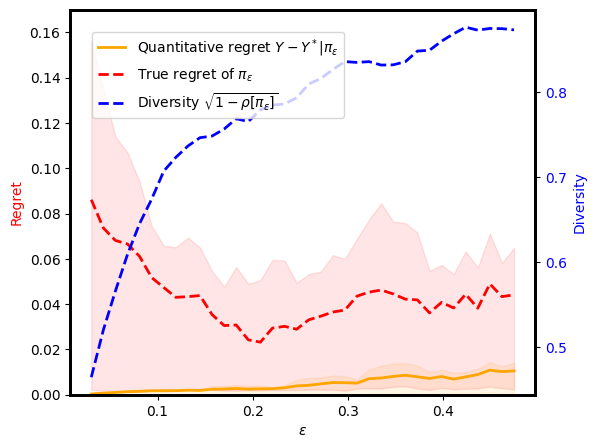

In [ ]:
regrets_D, regrets_Y, rhos = compute_regret_vs_eps(uQtD, QlD, eps_min=.005, eps_max=.5, n_eps=40, supp_A=[0,1], n_grid=1e3)

# np.save('regrets_uD_exp.npy', np.array(regrets_D))
# np.save('regrets_uY_exp.npy', np.array(regrets_Y))
# np.save('urhos_exp.npy', np.array(rhos))

# regrets_D = np.load('regrets_uD.npy')
# regrets_Y = np.load('regrets_uY.npy')
# rhos      = np.load('urhos.npy')

plot_regret_vs_eps(np.linspace(.005, .5, 40), regrets_D, regrets_Y, rhos, window_size=5)

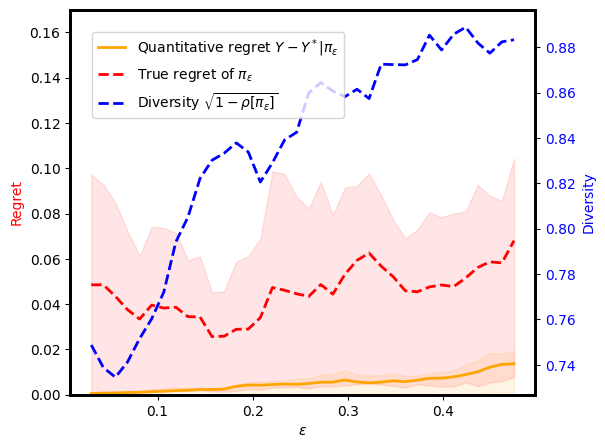

In [ ]:
# regrets_D, regrets_Y, rhos = compute_regret_vs_eps(bQtD, QlD, eps_min=.005, eps_max=.5, n_eps=40, supp_A=[0,1], n_grid=1e3)

# np.save('regrets_bD.npy', np.array(regrets_D))
# np.save('regrets_bY.npy', np.array(regrets_Y))
# np.save('brhos.npy', np.array(rhos))

regrets_D = np.load('regrets_bD.npy')
regrets_Y = np.load('regrets_bY.npy')
rhos      = np.load('brhos.npy')

plot_regret_vs_eps(np.linspace(.005, .5, 40), regrets_D, regrets_Y, rhos, window_size=5)

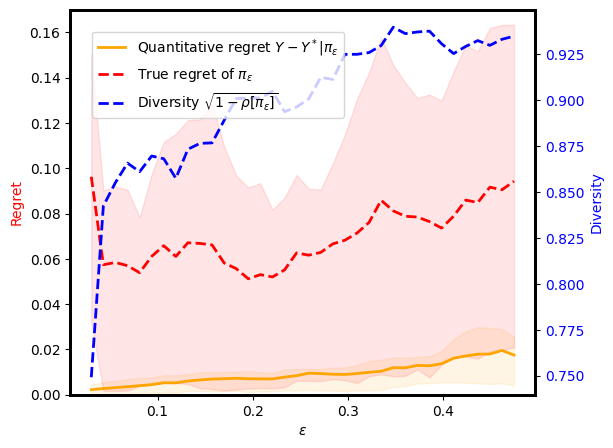

In [ ]:
# regrets_D, regrets_Y, rhos = compute_regret_vs_eps(tQtD, QlD, eps_min=.005, eps_max=.5, n_eps=40, supp_A=[0,1], n_grid=1e3)

# np.save('regrets_tD.npy', np.array(regrets_D))
# np.save('regrets_tY.npy', np.array(regrets_Y))
# np.save('trhos.npy', np.array(rhos))

regrets_D = np.load('regrets_tD.npy')
regrets_Y = np.load('regrets_tY.npy')
rhos      = np.load('trhos.npy')

plot_regret_vs_eps(np.linspace(.005, .5, 40), regrets_D, regrets_Y, rhos, window_size=5)

##### Regret vs Number of Generated Samples

In [ ]:
A      = np.linspace(supp_A[0], supp_A[1], int(n_grid))
policy = EpsilonOptimalUniformPolicy(eps=0.15, QtD=uQtD, supp_A=supp_A, n_grid=n_grid)

for num_samples in np.arange(5, 105, 10):
    regrets = []
    for n in range(20):
        # D
        U     = QlD.U(A)
        Y     = uQtD.Y(A)
        D     = p * Y + (1 - p) * U
        # generated D
        _, _inds = policy.generate(num_samples)
        _D       = D[_inds]
        # regret
        regret = np.max(D) - np.max(_D)
        assert regret >= 0, "Regret must be positive!"
        regrets.append(regret)
    print("number of samples: %d, regret: %.5f" % (num_samples, np.mean(regrets)))

number of samples: 5, regret: 0.06995
number of samples: 15, regret: 0.02890
number of samples: 25, regret: 0.01300
number of samples: 35, regret: 0.01560
number of samples: 45, regret: 0.00529
number of samples: 55, regret: 0.00486
number of samples: 65, regret: 0.01310
number of samples: 75, regret: 0.00208
number of samples: 85, regret: 0.01570
number of samples: 95, regret: 0.03352


### Diversified Iterative Search

However, despite the success of generative models in various fields, applying these techniques to integer optimization problems—such as routing, assignment, and scheduling—presents unique challenges. These problems are often characterized by discrete and combinatorical structures, where the solution space is non-continuous and highly constrained. Traditional methods in integer programming focus on identifying a single optimal solution, often using techniques such as branch and bound or cutting planes. These methods are not inherently designed to generate a distribution of solutions, making the direct application of generative curation frameworks less straightforward.

To address this limitation, we propose an iterative approach that enables the generation of diverse solutions over multiple iterations. This approach allows the model to incrementally refine the solution set, ultimately converging to a distribution that can provably approximate the optimal solution distribution. Through each iteration, the generated solutions increasingly reflect the desired balance between diversity and optimality, leveraging the strengths of generative methods while addressing the unique constraints posed by complex  optimization problems.

100%|██████████| 20/20 [00:48<00:00,  2.44s/it]


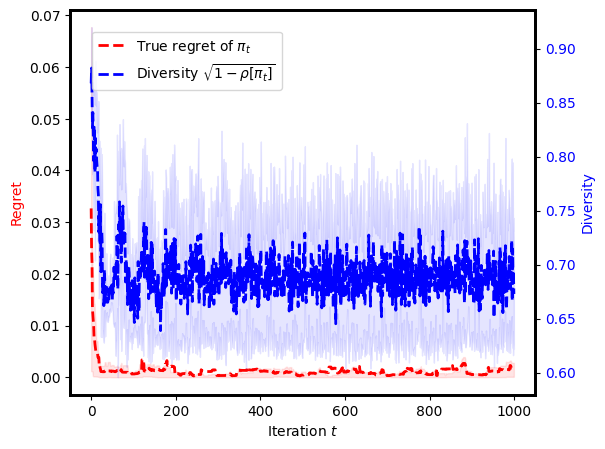

0.0020319917455193957 9.163691891327376e-05 0.0027834147547134425 0.6727320099328938


In [ ]:
from tqdm import tqdm

def moving_average(arr, window_size):
    """
    Compute the moving average of a 1D array with a given window size and remove NaN values.

    Parameters:
    arr (list or np.ndarray): The input array of values.
    window_size (int): The size of the moving average window.

    Returns:
    np.ndarray: The moving average of the input array with NaN values removed.
    """
    # Ensure the window size is valid
    if window_size is None:
        return arr

    # Convert the input array to a numpy array if it is not already
    arr = np.asarray(arr)

    # Compute the moving average using convolution
    cumsum = np.cumsum(arr, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    moving_avg = cumsum[window_size - 1:] / window_size

    return moving_avg

def plot_regret_vs_iterations(iters, regrets_D, diversity, lpct=20, upct=80, window_size=None):
    """
    Plots the regret vs epsilon.
    """
    fig, ax1 = plt.subplots(figsize=(6, 5))
    iters    = moving_average(iters, window_size)
    # diversity
    mean_div      = moving_average(np.mean(diversity, 1), window_size)
    max_div       = moving_average(np.percentile(diversity, upct, 1), window_size)
    min_div       = moving_average(np.percentile(diversity, lpct, 1), window_size)
    # regret
    mean_regret_D = moving_average(np.mean(regrets_D, 1), window_size)
    max_regret_D  = moving_average(np.percentile(regrets_D, upct, 1), window_size)
    min_regret_D  = moving_average(np.percentile(regrets_D, lpct, 1), window_size)
    ax1.set_xlabel('Iteration $t$')
    ax1.set_ylabel('Regret', color='red')
    plt.fill_between(iters, min_regret_D, max_regret_D, color='red', alpha=0.1)
    ax1.plot(iters, mean_regret_D, color='red', linestyle='--', linewidth=2, label='True regret of $\pi_t$')
    # ax1.set_ylim(0, 0.17)

    # Create a secondary y-axis (right)
    ax2 = ax1.twinx()
    plt.fill_between(iters, min_div, max_div, color='blue', alpha=0.1)
    ax2.plot(iters, mean_div, color='blue', linestyle='--', linewidth=2, label=r'Diversity $\sqrt{1 - \rho[\pi_t]}$')
    ax2.set_ylabel('Diversity', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    for spine in ax1.spines.values():
        spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner
    for spine in ax2.spines.values():
        spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner
    fig.legend(loc='upper left', bbox_to_anchor=(0.15,0.85))
    plt.show()

class DIS_GC(object):
    """
    A class representing the DIS_GC algorithm.
    """
    def __init__(self, QtD, QlD, p, m=5, n=10, T=100, supp_A=[0,1], n_grid=1e3, noise_level=1e-3, rate=1.01, verbose=True):
        self.QtD    = QtD
        self.QlD    = QlD
        self.supp_A = supp_A
        self.n_grid = int(n_grid)
        self.rate   = rate
        self.p      = p
        self.T      = T
        self.m      = m
        self.n      = n                                                         # the number of history solutions in the state, it has to be odd number.
        self.A      = np.linspace(
            self.supp_A[0], self.supp_A[1], int(self.n_grid))                   # action                    [ n_grid ]
        self.Y      = self.QtD.Y(self.A)                                        # quantitative desirability [ n_grid ]
        self.D      = self.p * self.Y + (1 - self.p) * self.QlD.U(self.A)       # true desirability         [ n_grid ]
        # init state Bt
        Bt          = np.array([
            self.init_solver(noise_level)
            for _ in range(self.n) ])                                           # initial state             [ n ]
        # diversified interative search
        self.regrets    = []
        self.diversity  = []
        for t in range(self.T):
            noise_level = rate * noise_level
            Bt, div  = self.diversified_solver(Bt, noise_level)
            regret   = self.state_regret(Bt)
            self.regrets.append(regret)
            self.diversity.append(div)
            # break
            if t % 10 == 0 and verbose:
                print("iteration %d, noise_level: %f, regret: %f, diversity: %s" % (t, noise_level, regret, div))

    def init_solver(self, noise_level=.05):
        """
        The solver for intializing the state X.
        """
        opt_ind = np.argmax(self.p * self.Y + np.random.normal(0, noise_level, self.n_grid))
        return opt_ind

    def diversified_solver(self, Bt, noise_level=.05):
        """
        The solver for the diversified iterative search.
        """
        new_Bt = np.copy(Bt)
        # calculate diversity term
        dist      = np.tile(self.A, (self.n, 1)) - \
            np.tile(self.A[Bt], (self.n_grid, 1)).transpose()                   # [ n, n_grid ]
        rhos      = self.exponential_kernel(np.sqrt((dist) ** 2))
        Em        = np.sqrt(2 * np.log(self.m))
        diversity = np.sqrt(1 - rhos.mean(0)) * Em

        # determine the next action
        opt_ind   = np.argmax(self.p * self.Y +
                              (1 - self.p) * diversity +
                              np.random.normal(0, noise_level, int(self.n_grid)))

        # update the state
        new_Bt     = np.roll(new_Bt, shift=-1, axis=0)
        new_Bt[-1] = opt_ind
        return new_Bt, np.sqrt(1 - rhos.mean(0)[opt_ind])

    def exponential_kernel(self, dist, length_scale=5e-2):
        """
        Exponential kernel function.
        """
        return np.exp(- 0.5 * dist ** 2 / length_scale ** 2)

    def state_regret(self, Bt):
        """
        The regret measure.
        """
        return np.max(self.D) - np.max(self.D[Bt])

# Parameters
T          = 1000   # Number of iterations
p          = 0.8    # Relative weight between the two objectives
supp_A     = [0, 1] # Support of the actions
n_grid     = 1e3    # Number of grid in action space
uQtD       = UniModalDesirability(supp_A) # QuantitativeDesirability(supp_A)

num_trials = 20
regs       = []
divs       = []
for _ in tqdm(range(num_trials)):
    QlD  = QualitativeDesirability(supp_A)
    dis  = DIS_GC(uQtD, QlD, p=p, m=5, n=50, T=T, supp_A=supp_A, n_grid=n_grid, noise_level=2e-2, rate=1, verbose=False)
    regs.append(dis.regrets)
    divs.append(dis.diversity)
regs  = np.array(regs).transpose()
divs  = np.array(divs).transpose()

plot_regret_vs_iterations(np.arange(T), regs, divs, lpct=20, upct=80, window_size=None)

print(regs[-1, :].mean(), np.percentile(regs[-1, :], 20), np.percentile(regs[-1, :], 80), divs[-1].mean())

### Human Preference Feedback

The proposed framework offers a dual benefit: it not only narrows down the decision space to manageable and high-quality options but also captures valuable signals about human preferences.
By systematically presenting a curated set of options and analyzing the choices made by human decision-makers, this framework enables the collection of valuable feedback that reflects their implicit preferences, constraints, and priorities, thereby refining the understanding of qualitative objectives.
For instance, in a healthcare setting, the proposed framework can be used to present a subset of potential treatment plans to a physician. By analyzing the physician's choices, we can gain insights into their considerations, such as patient-specific factors or personal experience, that might not be explicitly documented in the decision criteria. This feedback loop can be further utilized to refine and enhance the algorithmic models, making future curation more aligned with human expertise and intuition.

Suppose we have two decisions, $a_1$ and $a_2$, generated based on the policy $\pi$. For simplicity, we assume $Y(a)$ is known and can be treated as a constant or included in the mean of the qualitative objective. A human decision-maker reviews these decisions and expresses a preference. For instance, if $a_1$ is preferred over $a_2$, it means $U(a_1) > U(a_2)$. It is clear that the qualitative desirability can be updated using its posterior distribution $U(a') | U(a_1) > U(a_2)$ for any new test point $a'$.

<ipython-input-17-a54b57f082ef>:94: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter((a1, a2), (2, -2), c=colors[i], s=50, zorder=10, edgecolors=(0, 0, 0), label="%s feedback" % ind_label)
<ipython-input-17-a54b57f082ef>:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_test, current_mean, 'k--', lw=2, label="%s updated $U$" % ind_label, color=colors[i])


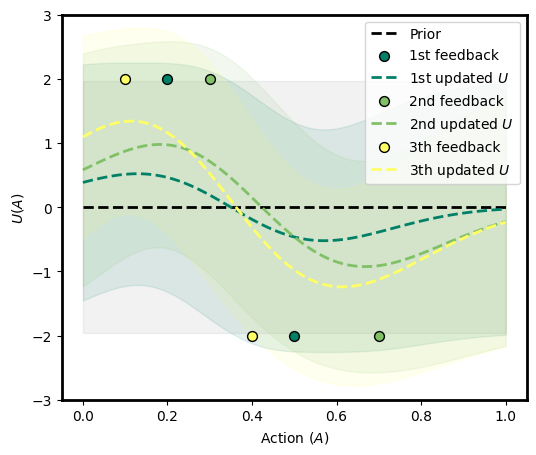

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.cm as cm

# Define the kernel function
def kernel(x, y, length_scale=1.0, variance=1.0):
    return variance * np.exp(-0.5 * ((x - y) / length_scale) ** 2)
    # return np.exp(- 0.5 * (x - y) ** 2 / 5e-2 ** 2)

# Compute the covariance matrices
def compute_covariance_matrix(X, Y, kernel):
    return np.array([[kernel(x, y) for y in Y] for x in X])

# GP Prior
def gp_prior(X, kernel):
    mean = np.zeros_like(X)
    cov = compute_covariance_matrix(X, X, kernel)
    return mean, cov

# Compute posterior given human feedback
def gp_posterior(X, a1, a2, kernel, mean_prior, cov_prior):
    k_a1_a1 = kernel(a1, a1)
    k_a2_a2 = kernel(a2, a2)
    k_a1_a2 = kernel(a1, a2)

    sigma_D2 = k_a1_a1 + k_a2_a2 - 2 * k_a1_a2
    sigma_D = np.sqrt(sigma_D2)
    alpha_D = 0 / sigma_D  # mu_D = 0

    k_a_prime_a1 = np.array([kernel(a, a1) for a in X])
    k_a_prime_a2 = np.array([kernel(a, a2) for a in X])
    k_a_prime_a_prime = np.array([kernel(a, a) for a in X])

    mu_U_prime = mean_prior
    sigma_U_prime2 = np.diag(cov_prior)
    cov_U_prime_D = k_a_prime_a1 - k_a_prime_a2

    phi_alpha_D = norm.pdf(alpha_D)
    Phi_alpha_D = norm.cdf(alpha_D)

    mu_U_prime_given_D = mu_U_prime + (cov_U_prime_D / sigma_D) * (phi_alpha_D / (1 - Phi_alpha_D))

    sigma_U_prime_given_D2 = (
        sigma_U_prime2
        - (cov_U_prime_D ** 2) / sigma_D2
        + ((cov_U_prime_D / sigma_D) ** 2) * sigma_D2 * (1 - (phi_alpha_D / (1 - Phi_alpha_D)) * (phi_alpha_D / (1 - Phi_alpha_D) + alpha_D))
    )

    posterior_mean = mu_U_prime_given_D
    posterior_cov = np.diag(sigma_U_prime_given_D2)

    return posterior_mean, posterior_cov

# Parameters
length_scale = 0.2
variance = 1.0
kernel_func = lambda x, y: kernel(x, y, length_scale, variance)

# Sequence of human feedback pairs
feedback_pairs = [(0.2, 0.5), (0.3, 0.7), (0.1, 0.4)]
# U1, U2 = 1.0, 0.0  # Assume U1 > U2 for each pair

# Test points
X_test = np.linspace(0, 1, 100)

# Initial GP Prior
prior_mean, prior_cov = gp_prior(X_test, kernel_func)

# Plotting the initial prior
fig, ax   = plt.subplots(figsize=(6, 5))
prior_std = np.sqrt(np.diag(prior_cov))
colors    = cm.summer(np.linspace(0, 1, len(feedback_pairs)))  # Continuous colormap
plt.fill_between(X_test, prior_mean - 1.96 * prior_std, prior_mean + 1.96 * prior_std, color="gray", alpha=0.1)
plt.plot(X_test, prior_mean, 'k--', lw=2, label='Prior')

# Sequentially update the posterior
current_mean = prior_mean
current_cov = prior_cov
for i, (a1, a2) in enumerate(feedback_pairs):
    current_mean, current_cov = gp_posterior(X_test, a1, a2, kernel_func, current_mean, current_cov)

    # Plotting each posterior
    posterior_std = np.sqrt(np.diag(current_cov))
    # label = f'1st Posterior' if i == 0 elif  f'{i+1}' else
    if i == 0:
        ind_label = '1st'
    elif i == 1:
        ind_label = '2nd'
    else:
        ind_label = '%dth' % (i+1)

    # if i == 0 or i == 1:
    plt.scatter((a1, a2), (2, -2), c=colors[i], s=50, zorder=10, edgecolors=(0, 0, 0), label="%s feedback" % ind_label)
    plt.fill_between(X_test, current_mean - 1.96 * posterior_std, current_mean + 1.96 * posterior_std, alpha=0.1, color=colors[i])
    plt.plot(X_test, current_mean, 'k--', lw=2, label="%s updated $U$" % ind_label, color=colors[i])

# plt.title('GP Prior and Sequential Posteriors with Human Feedback')
plt.xlabel('Action ($A$)')
plt.ylabel('$U(A)$')
plt.ylim(-3, 3)
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust the value to make the lines thicker or thinner
plt.legend()
plt.show()
